Ozuysal, Y. and S. A. Baccus (2012). "Linking the Computational Structure of Variance Adaptation to Biophysical Mechanisms." Neuron 73(5): 1002-1015.

# Import and functions

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy import ndimage
import pandas as pd
import os
import math


%matplotlib inline

In [ ]:
import import_ipynb
try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\retina_python\\Modules')
except:
    os.chdir('Modules')
from time_shifted_PID import MIfunc
from time_shifted_PID import EqualState
from Spike_Generation import SG
from Spike_Generation import NL

In [26]:
def NGD_TK(T, m, n, alpha, beta, g, tau_y):
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    y = np.zeros_like(x)
    z = np.zeros_like(x)
    
    for i in range(len(T)):
        y[i] = y[i-1] + dt*(-alpha*y[i-1]+m*x[i-1]-n*z[i-1])
        z[i] = z[i-1] + dt*( -beta*z[i-1]+g*y[i-1])
    return y[:len(T):50], z[:len(T):50]

# Set Parameter

In [27]:
m = 16.416565
n =	500
alpha = 41.464099
beta = 2.088120
g =  1729.111153/n
tau_y = 0.051583

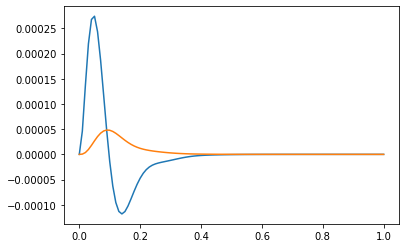

In [28]:
dt = 0.01
TKaxis = np.arange(101)*dt

k_E, k_S = NGD_TK(TKaxis, m, n, alpha, beta, g, tau_y)
# y_TK, w_TK = NGD_TK(TKaxis, *[2.67758918, 1.00000000, 1.17089092e+01, 4.69398540, 4.73653606e+02, 2.45547756e-02])
plt.plot(TKaxis, k_E)
plt.plot(TKaxis, k_S)

In [29]:
tot = 300
tAxis = np.arange(0,tot,dt)
# OU ; input
tau = 1
D = 1
OU=np.zeros(len(tAxis))
mu, sigma = 0, 1
for i in range(len(tAxis)-1):
    OU[i+1]=OU[i]*(1-dt/tau)+np.sqrt(D*dt)*np.random.normal(mu,sigma)
# filtering for OUSmoothed
Fc = 1
b, a = signal.butter(2, 2*Fc*dt, btype='low', analog=False)
LPOU = signal.filtfilt(b, a, OU)
x = (LPOU-np.mean(LPOU))/np.std(LPOU)

In [30]:
baseOutput = np.convolve(np.hstack((np.zeros(len(k_E)), x)), -k_E, 'full')[len(k_E):len(k_E)+len(x)]

(0.0, 5000.0)

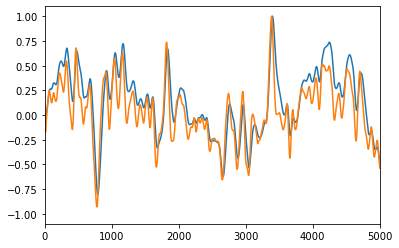

In [31]:
#Using notation of: J Neurophysiol 98: 1287–1296, 2007.
#Contrast Adaptation in a Nonadapting LGN Model
#Kate S. Gaudry and Pamela Reinagel

s = (x-min(x)) / (max(x)-min(x)) *2-1
g = (baseOutput-min(baseOutput))/(max(baseOutput)-min(baseOutput)) *2-1
# g = baseOutput/max(baseOutput)

plt.plot(-s)
plt.plot(g)
plt.xlim(0,5000)

# LNK

In [32]:
# four states kinetic model
# using the same notation as Ozuysal
# Eqn(11) in "Experimental Procedure" section

def kinetic(u,para,dt):
    ka  = para[0]
    kfr = para[1]
    kfi = para[2]
    ksr = para[3]
    ksi = para[4]
#   initial conditions for the four states
    p1 = 0.0
    p2 = 0
    p3 = 0.0
    p4 = 1.0

    p1r = []
    p2r = []
    p3r = []
    p4r = []
#
# 
#
    for i in range(len(u)):
        dp1 = (-u[i]*ka*p1  + kfr*p3)*dt
        dp2 =  (u[i]*ka*p1     - kfi*p2)*dt
        dp3 =  (kfi*p2 - (kfr+ksi)*p3 + u[i]*ksr*p4)*dt
        dp4 =  (ksi*p3 - u[i]*ksr*p4)*dt
    
        p1 = p1 + dp1
        p2 = p2 + dp2
        p3 = p3 + dp3
        p4 = p4 + dp4
    
        p1r.append(p1)
        p2r.append(p2)
        p3r.append(p3)
        p4r.append(p4)
        
# turn list into numpy arrays
    p1r = np.array(p1r)
    p2r = np.array(p2r)
    p3r = np.array(p3r)
    p4r = np.array(p4r)
    return (p1r,p2r,p3r,p4r)

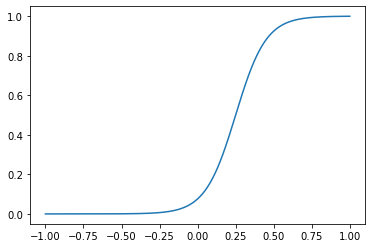

In [33]:
# Nonlinearity function
midpoint = 0.25 # position of the mid point of the nonlinear function (tanh)
DR = 5 # dynamical range (?) of the nonlinear function (tanh)
dummy = np.linspace(-1,1,1000)
plt.plot(dummy, (np.tanh((dummy-midpoint)*DR)+1)/2)

In [34]:
para = [60,20,3,0.03,1.0] # parameters for the five rates from Figure 2
para = [43,6,7,0.01,0.4] # parameters for the five rates from Figure 4

# DCCM

(5000.0, 6000.0)

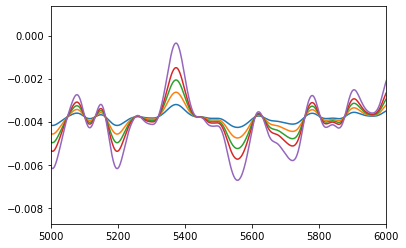

In [35]:
mean = 10
contrast_list = np.array([0.5,1,1.5,2,3])/mean
DCCM_output = [0]*len(contrast_list)
for i in range(len(contrast_list)):
    DCCM_output[i] = -np.convolve(np.hstack((np.zeros(len(k_E)), x))*contrast_list[i]*mean+mean, k_E, 'full')[len(k_E):len(k_E)+len(x)]
    plt.plot(DCCM_output[i])
plt.xlim(5000,6000)

(5000.0, 6000.0)

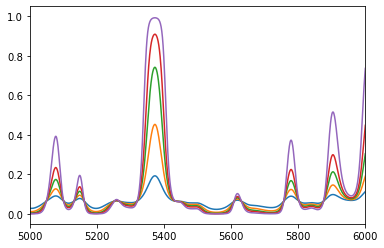

In [36]:

DCCM_output = [(output-min(DCCM_output[-1]))/(max(DCCM_output[-1])-min(DCCM_output[-1])) *2-1 for output in DCCM_output]
DCCM_u = [(np.tanh((output-midpoint)*DR)+1)/2 for output in DCCM_output] 
for i in range(len(contrast_list)):
    plt.plot(DCCM_u[i])
plt.xlim(5000,6000)

In [37]:
DCCM_A = [kinetic(u,para,dt)[1] for u in DCCM_u]

### STA

In [47]:
window = [-1,1] # second
timeaxis = np.arange(-100,101)*dt

DCCM_Xcorr = [0]*len(contrast_list)
for i in range(len(contrast_list)):
    Xcorr = np.correlate(x, DCCM_A[i] , 'same') / np.correlate(np.ones_like(x), DCCM_A[i], 'same')
    Xcorr = Xcorr[int(len(Xcorr)/2)-100 : int(len(Xcorr)/2)+101]
    DCCM_Xcorr[i] = Xcorr.copy()

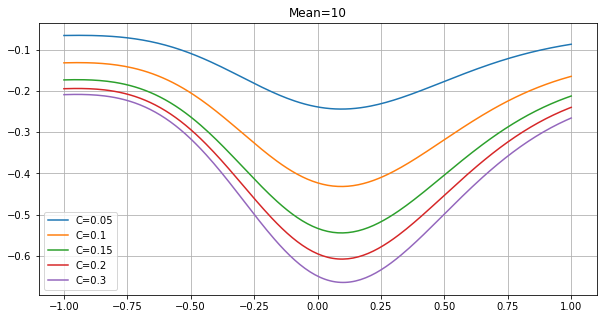

In [48]:
# plt.plot(timeaxis,baseXcorr, label= 'without gain', linestyle= 'dashed' )
for i in range(len(contrast_list)): 
    plt.plot(timeaxis,DCCM_Xcorr[i], label = 'C='+str(round(contrast_list[i],3)))
plt.legend()
plt.title('Mean='+str(mean))
plt.grid('on')
plt.gcf().set_size_inches(10,5)

# CCDM

(5000.0, 6000.0)

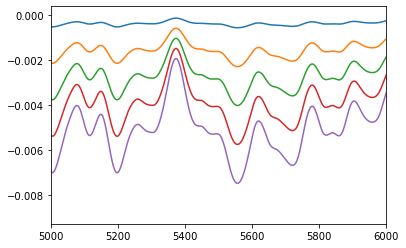

In [40]:
contrast = 0.2
mean_list = np.array([1,4,7,10,13])
CCDM_output = [0]*len(mean_list)
for i in range(len(mean_list)):
    CCDM_output[i] = -np.convolve(np.hstack((np.zeros(len(k_E)), x))*contrast*mean_list[i]+mean_list[i], k_E, 'full')[len(k_E):len(k_E)+len(x)]
    plt.plot(CCDM_output[i])
plt.xlim(5000,6000)

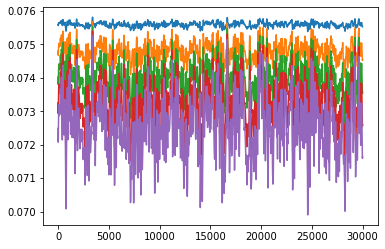

In [41]:
CCDM_output = [(output-min(DCCM_output[-1]))/(max(DCCM_output[-1])-min(DCCM_output[-1])) *2-1 for output in CCDM_output]
CCDM_u = [(np.tanh((output-midpoint)*DR)+1)/2 for output in CCDM_output] 
for i in range(len(mean_list)):
    plt.plot(CCDM_u[i])
# plt.xlim(5000,6000)

In [42]:
CCDM_A = [kinetic(u,para,dt)[1] for u in CCDM_u]

### STA

In [51]:
CCDM_Xcorr = [0]*len(mean_list)
for i in range(len(mean_list)):
    Xcorr = np.correlate(x, CCDM_A[i] , 'same') / np.correlate(np.ones_like(x), CCDM_A[i], 'same')
    Xcorr = Xcorr[int(len(Xcorr)/2)-100 : int(len(Xcorr)/2)+101]
    CCDM_Xcorr[i] = Xcorr.copy()

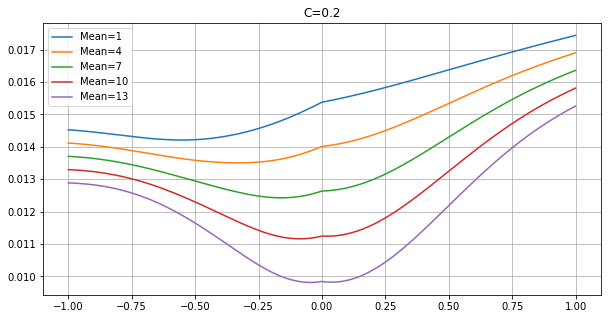

In [52]:
# plt.plot(timeaxis,baseXcorr, label= 'without gain', linestyle= 'dashed' )
for i in range(len(mean_list)): 
    plt.plot(timeaxis,CCDM_Xcorr[i], label = 'Mean='+str(round(mean_list[i])))
plt.legend()
plt.title('C='+str(contrast))
plt.grid('on')
plt.gcf().set_size_inches(10,5)